In [15]:
import random
import time
import math
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline


In [16]:
def build_test_graph():
    G = nx.Graph()
    edges = [
        (1, 2, 3),
        (1, 3, 1),
        (2, 3, 3),
        (2, 4, 1),
        (3, 4, 3),
        (3, 5, 2),
        (4, 5, 4),
    ]
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)
    return G

G = build_test_graph()
print("Nodes:", list(G.nodes()))
print("Edges:", list(G.edges(data=True)))


Nodes: [1, 2, 3, 4, 5]
Edges: [(1, 2, {'weight': 3}), (1, 3, {'weight': 1}), (2, 3, {'weight': 3}), (2, 4, {'weight': 1}), (3, 4, {'weight': 3}), (3, 5, {'weight': 2}), (4, 5, {'weight': 4})]


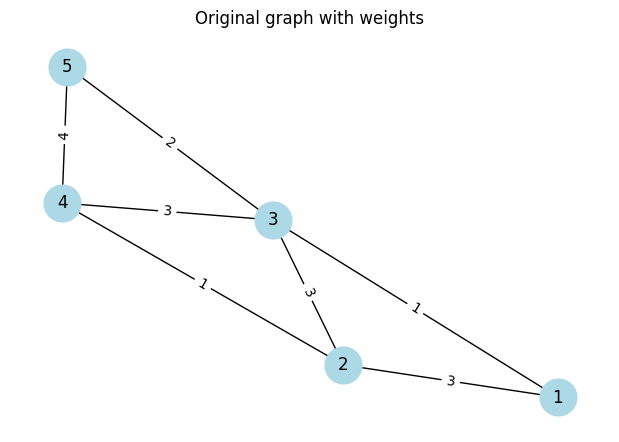

In [17]:
pos = nx.spring_layout(G, seed=0)

plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=700)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Original graph with weights")
plt.axis("off")
plt.show()


In [18]:
def karger_min_cut_with_visualization(G, show_steps=True):
    H = G.copy()
    supernode_map = {node: {node} for node in H.nodes()}
    pos = nx.spring_layout(H, seed=0)
    
    step = 0
    while len(H.nodes()) > 2:
        # Always sample the edge to contract
        edges = []
        weights = []
        for u, v, data in H.edges(data=True):
            w = data.get("weight", 1.0)
            edges.append((u, v))
            weights.append(w)
        
        (u, v) = random.choices(edges, weights=weights, k=1)[0]
        
        if show_steps:
            plt.figure(figsize=(6, 4))
            node_colors = ['lightblue'] * len(H.nodes())
            nodes = list(H.nodes())
            u_idx = nodes.index(u)
            v_idx = nodes.index(v)
            node_colors[u_idx] = 'red'
            node_colors[v_idx] = 'red'
            
            nx.draw(H, pos, with_labels=True, node_color=node_colors, node_size=700)
            edge_labels = nx.get_edge_attributes(H, "weight")
            nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels)
            plt.title(f"Step {step}: Merging nodes {u} and {v}")
            plt.axis("off")
            plt.show()
        
        # Now contract u and v
        supernode_map[u] |= supernode_map[v]
        del supernode_map[v]
        
        for nbr in list(H.neighbors(v)):
            if nbr == u:
                continue
            w = H[v][nbr].get("weight", 1.0)
            if H.has_edge(u, nbr):
                H[u][nbr]["weight"] += w
            else:
                H.add_edge(u, nbr, weight=w)
        
        H.remove_node(v)
        if H.has_edge(u, u):
            H.remove_edge(u, u)
        
        step += 1
    
    if show_steps:
        plt.figure(figsize=(6, 4))
        nx.draw(H, pos, with_labels=True, node_color="lightblue", node_size=700)
        edge_labels = nx.get_edge_attributes(H, "weight")
        nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels)
        plt.title(f"Final graph with {len(H.nodes())} supernodes")
        plt.axis("off")
        plt.show()
    
    nodes = list(H.nodes())
    a, b = nodes[0], nodes[1]
    cut_value = H[a][b].get("weight", 0.0)
    S = supernode_map[a]
    T = supernode_map[b]
    
    return cut_value, (S, T)


In [23]:
def run_karger_multiple_times(G, num_runs=100, show_steps=False):
    results = []
    for i in range(num_runs):
        cut_value, (S, T) = karger_min_cut_with_visualization(G, show_steps=show_steps)
        results.append({
            "run": i+1,
            "cut_value": cut_value,
            "partition_S": S,
            "partition_T": T
        })
        if (i+1) % 20 == 0:
            print(f"Completed {i+1}/{num_runs} runs")
    return results

# 1) Run Karger many times on the same graph G
results = run_karger_multiple_times(G, num_runs=100, show_steps=False)

# 2) Convert the list of dicts into a DataFrame
import pandas as pd
df = pd.DataFrame(results)
df.head()


Completed 20/100 runs
Completed 40/100 runs
Completed 60/100 runs
Completed 80/100 runs
Completed 100/100 runs


,run,cut_value,partition_S,partition_T
0,1,5,"{1, 2}","{3, 4, 5}"
1,2,5,"{1, 2}","{3, 4, 5}"
2,3,4,{1},"{2, 3, 4, 5}"
3,4,9,"{1, 2, 4, 5}",{3}
4,5,4,{1},"{2, 3, 4, 5}"


In [24]:
df = pd.DataFrame(results)
df.to_csv("karger_results.csv", index=False)
print("Results saved to karger_results.csv")


Results saved to karger_results.csv


In [25]:
df = pd.read_csv("karger_results.csv")
print("Best cut value:", df["cut_value"].min())
print("Frequency of best cut:", (df["cut_value"] == df["cut_value"].min()).sum())


Best cut value: 4
Frequency of best cut: 39


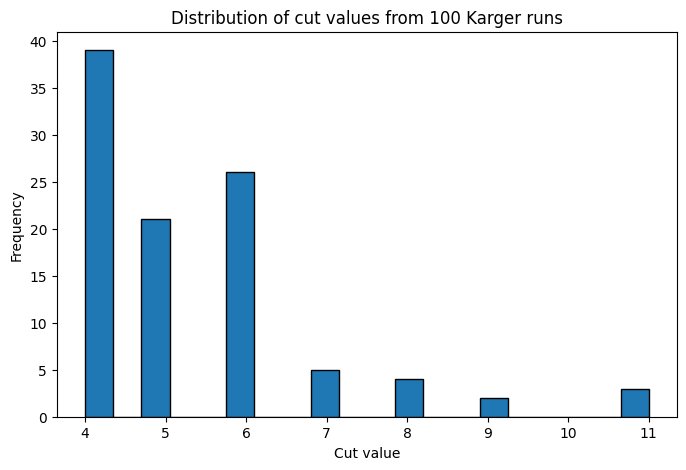

In [26]:
plt.figure(figsize=(8, 5))
plt.hist(df["cut_value"], bins=20, edgecolor='black')
plt.title("Distribution of cut values from 100 Karger runs")
plt.xlabel("Cut value")
plt.ylabel("Frequency")
plt.show()
